In [20]:
#Importing the required libraries 
%matplotlib inline
import numpy  as np  
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import keras
import h5py
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import glob

from keras.datasets import mnist, fashion_mnist, cifar10

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint, Callback

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import Sequential
from keras.models import load_model

from keras.layers import Input, Dense, TimeDistributed
from keras.layers import LSTM
from keras.layers import Dense, Dropout, Reshape, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Activation, MaxPool2D, Convolution2D, UpSampling2D, Conv2DTranspose, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU

from keras import backend as K

from keras.utils import np_utils
from keras.utils.np_utils import to_categorical,normalize

from keras import optimizers
from keras.optimizers import SGD, RMSprop, Adam, Nadam

import pickle
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import classification_report, confusion_matrix
#from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

import datetime
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!nvidia-smi

Sat Dec 14 18:45:58 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
os.chdir("/content/drive/My Drive/MiniProject4")

In [0]:
# Mehdi
class MNIST_GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100 #Input Noise Dimension 
        self.losses = {"D_real":[], "D_accuracy":[] ,"G":[]}

        optimizer = Adam(0.0002, 0.5, amsgrad=True)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                    optimizer=optimizer,
                                    metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        #model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=64, sample_interval=200):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train -127.5) / 127.5 #- 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        temp=[]
        for epoch in range(epochs+1):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
         
            self.losses["D_real"].append(d_loss[0])
            self.losses["D_accuracy"].append(d_loss[1]) 
            self.losses["G"].append(g_loss)
            #with open('Generic_GAN_mehdi_RMS.pickle', 'wb') as handle:
            #  pickle.dump(self.losses, handle, protocol=pickle.HIGHEST_PROTOCOL)

            # Plot the progress
            
            if epoch%1000==0:
                  print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
              #self.sample_images(epoch)

            # Checkpointing
            temp.append(100*(1-d_loss[1]))
            if epoch>(epochs-500) and temp[epoch]>temp[epoch-1]:
                  self.generator.save("./saved_model/mnist_generator_mehdi_LD100.h5")

            #if epoch == (epochs-1):            
              #self.gan_test(model_file="./saved_model/mnist_generator_mehdi_LD1k.h5",path="./imgs/GAN_1LD1k/image")
             
        self.plot_loss()

    def gan_test(self, model_file, path,num_examples=15000):
        self.generator = self.build_generator()
        self.generator.load_weights(model_file)
        noise = np.random.normal(0, 1, (num_examples, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        print(gen_imgs.shape)
        
        for i in range(num_examples):
            plt.imsave(path+str(i)+".png", gen_imgs[i, :, :, 0], cmap = "gray")

    def sample_images(self, epoch):
        r, c = 5,5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/mehdiLD1k_%d.png" % epoch)
        plt.close()

    def plot_loss(self):
        dis_loss = [v for v in self.losses["D_real"]]
        #dis_accuracy = 100*[v for v in self.losses["D_accuracy"]]
        gen_loss = [v for v in self.losses["G"]]
        #d_acc = [v[1] for v in losses["D"]]
        #g_acc = [v[1] for v in losses["G"]]

        plt.figure(figsize=(10,8))
        plt.plot(dis_loss, label="Discriminator loss")
        #plt.plot(dis_accuracy, label="Discriminator accuracy")
        plt.plot(gen_loss, label="Generator loss")
        #plt.plot(d_acc, label="Discriminator accuracy")
        #plt.plot(g_acc, label="Generator accuracy")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('GAN')
        plt.legend()
       # plt.savefig("./GAN_mehdi_rms_loss_LD1k.png")
        plt.show()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_____________________________________________

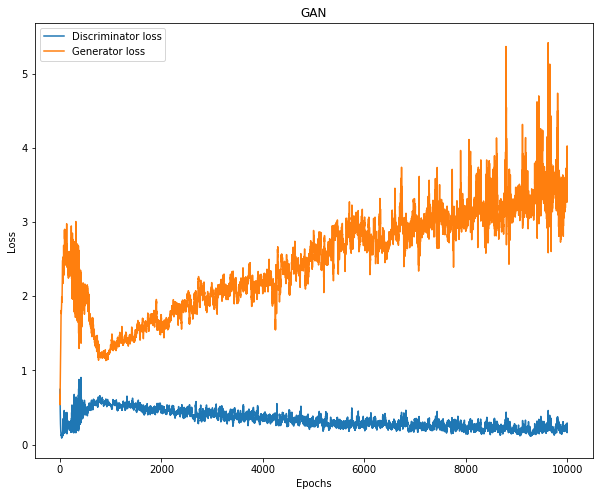

In [0]:
#Latent Dim=1
gan_mehdi = MNIST_GAN()
gan_mehdi.train(epochs=10001,batch_size=1000)

In [0]:
#Latent Dim=10
gan_mehdi = MNIST_GAN()
gan_mehdi.train(epochs=10001,batch_size=1000)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_____________________________________________

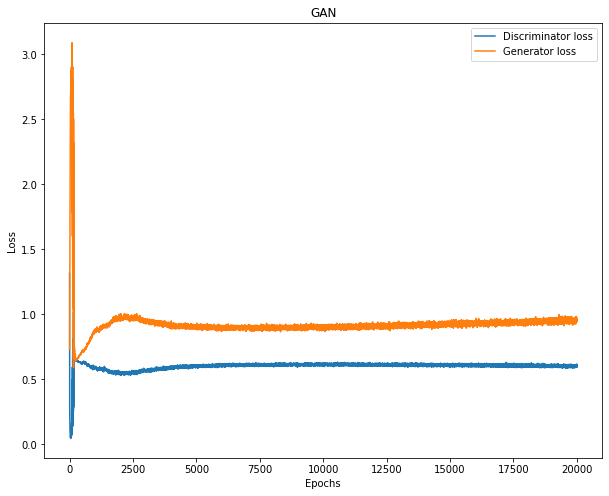

In [7]:
#Latent Dim=100
gan_mehdi = MNIST_GAN()
gan_mehdi.train(epochs=20001,batch_size=1000)

In [9]:
gan_mehdi.gan_test(model_file = "./saved_model/mnist_generator_mehdi_LD100.h5",path="./imgs/10k/image",
             num_examples = 10000)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dense_8 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dense_9 (Dense)              (None, 784)              

In [10]:
gan_mehdi.gan_test(model_file = "./saved_model/mnist_generator_mehdi_LD100.h5",path="./imgs/15k/image",
             num_examples = 15000)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
dense_11 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
dense_12 (Dense)             (None, 784)              

In [11]:
gan_mehdi.gan_test(model_file = "./saved_model/mnist_generator_mehdi_LD100.h5",path="./imgs/30k/image",
             num_examples = 30000)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
dense_14 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 512)               2048      
_________________________________________________________________
dense_15 (Dense)             (None, 784)              

In [16]:
gan_mehdi.gan_test(model_file = "./saved_model/mnist_generator_mehdi_LD100.h5",path="./imgs/50k/image",
             num_examples = 50000)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 256)               1024      
_________________________________________________________________
dense_17 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
dense_18 (Dense)             (None, 784)              




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_____________________________________________

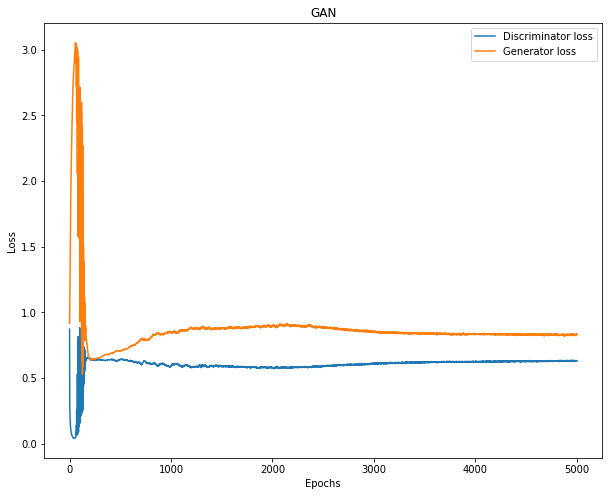

In [0]:
#Latent Dim=1000
gan_mehdi = MNIST_GAN()
gan_mehdi.train(epochs=5001,batch_size=5000)

In [0]:
def log_mean_exp(t):
    # prevent overflow
    # \sum{i=1}^n e^{x_i} = e^\max{x_j} \sum{i=1}^n e^{x_i-\max{x_j}}
    max_ = t.max(1, keepdims=True)
    return np.squeeze(max_) + np.log(np.mean(np.exp(t - max_), 1)) # log-likelihood


def parzen_batch(x, mu, sigma):
    '''
        x: [batch_size, z_dim]
        mu: [n, z_dim]
        sigma: float scalar
    '''

    x = np.expand_dims(x, axis=1)
    mu = np.expand_dims(mu, axis=0)
    t = (((x - mu) / sigma)**2).sum(2)*(-0.5)
    E = log_mean_exp(t)
    Z = mu.shape[2] * np.log(sigma*np.sqrt(2*np.pi))
    return E - Z


def get_lls(x, mu, sigma, batch_size=10):
    lls = np.array([])
    num_samples = x.shape[0]
    num_batches = (num_samples+batch_size-1)//batch_size
    for i in range(num_batches):
        ll = parzen_batch(x[(i*batch_size):min((i+1)*batch_size, num_samples)], mu, sigma)
        lls = np.append(lls, ll)
    return lls


def cross_validate_sigma(x, mu, sigmas, batch_size=10):
    '''
        x: validation data
        mu: generative data
        sigmas: sigma sequence
    '''
    lls = []
    for sigma in sigmas:
        ll = get_lls(x, mu, sigma, batch_size=batch_size)
        lls.append(ll.mean())
        print('Sigma: {}, LL: {}'.format(sigma, ll.mean()))
    return sigmas[np.argmax(lls)]
    


    
def main_run(gen_data_path, limit_size = 100, batch_size = 50, cross_val = 10, sigma_start = -1, sigma_end = 0., file = "gan_mnist.txt"):
#    parser = argparse.ArgumentParser(description = 'Gaussian parzen window, negative log-likelihood estimator.')
#    parser.add_argument('-d', '--data_dir', default='/home/clb/dataset/mnist',  help='Directory to load mnist.')
#    parser.add_argument('-g', '--gen_data_path', default='result/scgan_mnist/scgan_mnist.npy', help='Path to load generative data.')
#    parser.add_argument('-l', '--limit_size', default=1000, type=int, help='The number of samples in validation.')
#    parser.add_argument('-b', '--batch_size', default=100, type=int)
#    parser.add_argument('-c', '--cross_val', default=10, type=int,
#                            help="Number of cross valiation folds")
#    parser.add_argument('--sigma_start', default=-1, type=float)
#    parser.add_argument('--sigma_end', default=0., type=float)
#    parser.add_argument('--file', default='cgan_mnist.txt', help='File to save mean and std of log-likelihood.')
#    args = parser.parse_args()

    # load mnist
    (trainX, trainY), (testX, testY) = mnist.load_data()
    trainX = trainX.reshape([-1, 784]).astype(np.float32)/255.
    testX = testX.reshape([-1, 784]).astype(np.float32)/255.

    x = trainX[-limit_size:]
    mu = np.array([cv2.imread(filename, 0) for filename in glob.glob(gen_data_path)]).reshape([-1, 784]).astype(np.float32)/255.
    print(mu.shape)
    print(x.shape)
    #raise Exception("stop")
    #mu = np.load(gen_data_path).astype(np.float32)/255.

    sigmas = np.logspace(sigma_start, sigma_end, cross_val)
    sigma = cross_validate_sigma(x, mu, sigmas, batch_size)
    print('Using Sigma: {}'.format(sigma))
    lls = get_lls(testX, mu, sigma, batch_size)
    print('Negative Log-Likelihood of Test Set = {}, Std: {}'.format(lls.mean(), lls.std()/np.sqrt(testX.shape[0])))
    #with open(file, 'w') as f:
    #    f.write('Negative Log-Likelihood of Test Set = {}, Std: {}\n'.format(lls.mean(), lls.std()/np.sqrt(testX.shape[0]))) 


In [13]:
main_run(gen_data_path = "./imgs/10k/*.png")

(10000, 784)
(100, 784)
Sigma: 0.1, LL: -266.5783972167969
Sigma: 0.1291549665014884, LL: 70.39375854492188
Sigma: 0.16681005372000587, LL: 192.07088470458984
Sigma: 0.21544346900318834, LL: 184.68459747314452
Sigma: 0.2782559402207124, LL: 99.93286560058594
Sigma: 0.35938136638046275, LL: -31.18948471069336
Sigma: 0.46415888336127786, LL: -190.0988833618164
Sigma: 0.5994842503189409, LL: -365.64209930419923
Sigma: 0.774263682681127, LL: -551.1042822265625
Sigma: 1.0, LL: -742.4135314941407
Using Sigma: 0.16681005372000587
Negative Log-Likelihood of Test Set = 204.86485932006835, Std: 2.199656943450127


In [14]:
main_run(gen_data_path = "./imgs/15k/*.png")

(15000, 784)
(100, 784)
Sigma: 0.1, LL: -152.2576446533203
Sigma: 0.1291549665014884, LL: 138.7702770996094
Sigma: 0.16681005372000587, LL: 232.90628295898438
Sigma: 0.21544346900318834, LL: 209.01203048706054
Sigma: 0.2782559402207124, LL: 114.36712448120117
Sigma: 0.35938136638046275, LL: -22.681954002380373
Sigma: 0.46415888336127786, LL: -185.1406086730957
Sigma: 0.5994842503189409, LL: -362.8116943359375
Sigma: 0.774263682681127, LL: -549.5545422363281
Sigma: 1.0, LL: -741.6390533447266
Using Sigma: 0.16681005372000587
Negative Log-Likelihood of Test Set = 222.7595012817383, Std: 2.128629760833915


In [15]:
main_run(gen_data_path = "./imgs/30k/*.png")

(30000, 784)
(100, 784)
Sigma: 0.1, LL: -111.9973876953125
Sigma: 0.1291549665014884, LL: 162.6284552001953
Sigma: 0.16681005372000587, LL: 246.93435424804687
Sigma: 0.21544346900318834, LL: 217.15084060668946
Sigma: 0.2782559402207124, LL: 118.97965103149414
Sigma: 0.35938136638046275, LL: -20.17761951446533
Sigma: 0.46415888336127786, LL: -183.88651473999025
Sigma: 0.5994842503189409, LL: -362.2814562988281
Sigma: 0.774263682681127, LL: -549.4199420166016
Sigma: 1.0, LL: -741.6769323730468
Using Sigma: 0.16681005372000587
Negative Log-Likelihood of Test Set = 249.87869375, Std: 2.0422525360303014


In [17]:
main_run(gen_data_path = "./imgs/50k/*.png")

(50000, 784)
(100, 784)
Sigma: 0.1, LL: -69.85740234375
Sigma: 0.1291549665014884, LL: 187.68378051757813
Sigma: 0.16681005372000587, LL: 261.74779327392577
Sigma: 0.21544346900318834, LL: 225.8257897949219
Sigma: 0.2782559402207124, LL: 123.9777653503418
Sigma: 0.35938136638046275, LL: -17.376212997436525
Sigma: 0.46415888336127786, LL: -182.38806472778322
Sigma: 0.5994842503189409, LL: -361.5450244140625
Sigma: 0.774263682681127, LL: -549.1108337402344
Sigma: 1.0, LL: -741.5752514648437
Using Sigma: 0.16681005372000587
Negative Log-Likelihood of Test Set = 269.2332712677002, Std: 1.9694366023104808


In [0]:
main_run(gen_data_path = "./imgs/GAN_1LD10/*.png")

(15000, 784)
(100, 784)
Sigma: 0.1, LL: -306.8723016357422
Sigma: 0.1291549665014884, LL: 46.08647399902344
Sigma: 0.16681005372000587, LL: 177.35158996582032
Sigma: 0.21544346900318834, LL: 175.72068710327147
Sigma: 0.2782559402207124, LL: 94.42779769897462
Sigma: 0.35938136638046275, LL: -34.61196327209473
Sigma: 0.46415888336127786, LL: -192.25341262817383
Sigma: 0.5994842503189409, LL: -366.99708587646484
Sigma: 0.774263682681127, LL: -551.9072155761719
Sigma: 1.0, LL: -742.7601776123047
Using Sigma: 0.16681005372000587
Negative Log-Likelihood of Test Set = 201.5950366333008, Std: 2.1213984425269006


In [0]:
main_run(gen_data_path = "./imgs/GAN_1LD1k/*.png")

(15000, 784)
(100, 784)
Sigma: 0.1, LL: -249.16602478027343
Sigma: 0.1291549665014884, LL: 80.68102416992187
Sigma: 0.16681005372000587, LL: 198.09046569824218
Sigma: 0.21544346900318834, LL: 188.1498695373535
Sigma: 0.2782559402207124, LL: 101.87038208007813
Sigma: 0.35938136638046275, LL: -30.163629035949707
Sigma: 0.46415888336127786, LL: -189.60845611572265
Sigma: 0.5994842503189409, LL: -365.4500274658203
Sigma: 0.774263682681127, LL: -551.0514642333984
Sigma: 1.0, LL: -742.3652020263672
Using Sigma: 0.16681005372000587
Negative Log-Likelihood of Test Set = 217.24773363342285, Std: 2.0665999461272437


In [0]:

class DCGAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100 #Input Noise Dimension 
        self.losses = {"D_real":[], "D_accuracy":[] ,"G":[]}

        optimizer = Adam(0.0002, 0.5, amsgrad=True)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                    optimizer=optimizer,
                                    metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(BatchNormalization(momentum=0.9))
        model.add(LeakyReLU(alpha=0.1))
        model.add(Reshape((7, 7, 128)))

        #model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=5, padding="same"))
        model.add(BatchNormalization(momentum=0.9))
        model.add(LeakyReLU(alpha=0.1))
        #model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2DTranspose(128, 4, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.9))
        model.add(LeakyReLU(alpha=0.1))
        #model.add(Activation("relu"))
        model.add(Conv2D(128, kernel_size=5, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.9))
        model.add(LeakyReLU(alpha=0.1))
        model.add(Conv2D(128, kernel_size=5, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.9))
        model.add(LeakyReLU(alpha=0.1))
        model.add(Conv2D(self.channels, kernel_size=5, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(128, kernel_size=3, strides=1, input_shape=self.img_shape, padding="same"))
        model.add(BatchNormalization(momentum=0.9))
        model.add(LeakyReLU(alpha=0.1))
        #model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
        #model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.9))
        model.add(LeakyReLU(alpha=0.1))
        #model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.9))
        model.add(LeakyReLU(alpha=0.1))
        #model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.9))
        model.add(LeakyReLU(alpha=0.1))
        
        model.add(Flatten())
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))


        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=64, sample_interval=200):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train -127.5) / 127.5 #- 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        temp=[]
        for epoch in range(epochs+1):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
         
            self.losses["D_real"].append(d_loss[0])
            self.losses["D_accuracy"].append(d_loss[1]) 
            self.losses["G"].append(g_loss)
            #with open('Generic_GAN_mehdi_RMS.pickle', 'wb') as handle:
            #  pickle.dump(self.losses, handle, protocol=pickle.HIGHEST_PROTOCOL)

            # Plot the progress
            if epoch%1000==0:
              print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
              self.sample_images(epoch)

            # Checkpointing
            temp.append(100*(1-d_loss[1]))
            if epoch>(epochs-500) and temp[epoch]>temp[epoch-1]:
              self.generator.save("./saved_model/mnist_generator_new.h5")

            if epoch == (epochs-1):            
              self.gan_test(model_file="./saved_model/mnist_generator_new.h5",path="./imgs/GAN_new/image")
              
        self.plot_loss()

    def gan_test(self, model_file, path,num_examples=15000):
        #self.generator = self.build_generator()
        self.generator.load_weights(model_file)
        noise = np.random.normal(0, 1, (num_examples, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        print(gen_imgs.shape)
        
        for i in range(num_examples):
            plt.imsave(path+str(i)+".png", gen_imgs[i, :, :, 0], cmap = "gray")

    def sample_images(self, epoch):
        r, c = 5,5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/new_%d.png" % epoch)
        plt.close()

    def plot_loss(self):
        dis_loss = [v for v in self.losses["D_real"]]
        #dis_accuracy = 100*[v for v in self.losses["D_accuracy"]]
        gen_loss = [v for v in self.losses["G"]]
        #d_acc = [v[1] for v in losses["D"]]
        #g_acc = [v[1] for v in losses["G"]]

        plt.figure(figsize=(10,8))
        plt.plot(dis_loss, label="Discriminator loss")
        #plt.plot(dis_accuracy, label="Discriminator accuracy")
        plt.plot(gen_loss, label="Generator loss")
        #plt.plot(d_acc, label="Discriminator accuracy")
        #plt.plot(g_acc, label="Generator accuracy")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('GAN')
        plt.legend()
        plt.savefig("./GAN_new_rms_loss.png")
        plt.show()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 6272)              633472    
_________________________________________________________________
batch_normalization_31 (Batc (None, 6272)              25088     
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 7, 7, 128)         409728    
_________________________________________________________________
batch_normalization_32 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 7, 7, 128)       

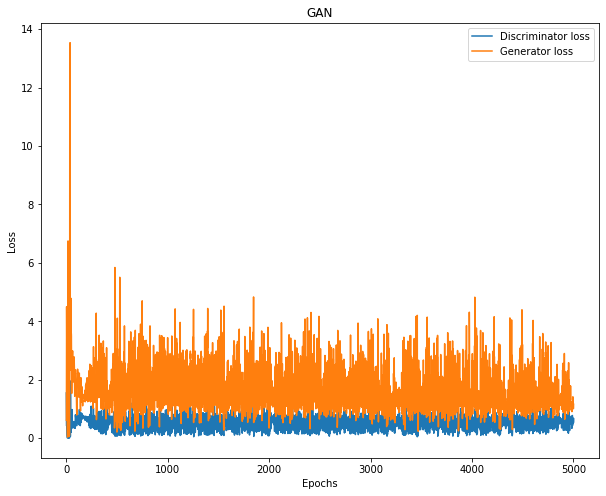

In [0]:
#Latent Dim=100
gan = DCGAN()
gan.train(epochs=5001,batch_size=1000)

In [0]:
main_run(gen_data_path = "./imgs/DCGAN_new/*.png")

(15000, 784)
(100, 784)
Sigma: 0.1, LL: -119.94199462890624
Sigma: 0.1291549665014884, LL: 158.13709197998048
Sigma: 0.16681005372000587, LL: 244.50840118408203
Sigma: 0.21544346900318834, LL: 215.9555355834961
Sigma: 0.2782559402207124, LL: 118.50912567138671
Sigma: 0.35938136638046275, LL: -20.232368507385253
Sigma: 0.46415888336127786, LL: -183.7156089782715
Sigma: 0.5994842503189409, LL: -362.00575103759763
Sigma: 0.774263682681127, LL: -549.1269812011719
Sigma: 1.0, LL: -741.4492785644532
Using Sigma: 0.16681005372000587
Negative Log-Likelihood of Test Set = 226.71905489501953, Std: 2.1460352946340056


In [0]:

class DCGAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100 #Input Noise Dimension 
        self.losses = {"D_real":[], "D_accuracy":[] ,"G":[]}

        optimizer = Adam(0.0002, 0.5, amsgrad=True)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                    optimizer=optimizer,
                                    metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=64, sample_interval=200):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train -127.5) / 127.5 #- 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        temp=[]
        for epoch in range(epochs+1):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
         
            self.losses["D_real"].append(d_loss[0])
            self.losses["D_accuracy"].append(d_loss[1]) 
            self.losses["G"].append(g_loss)
            #with open('Generic_GAN_mehdi_RMS.pickle', 'wb') as handle:
            #  pickle.dump(self.losses, handle, protocol=pickle.HIGHEST_PROTOCOL)

            # Plot the progress
            if epoch%1000==0:
              print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
              self.sample_images(epoch)

            # Checkpointing
            temp.append(100*(1-d_loss[1]))
            if epoch>(epochs-500) and temp[epoch]>temp[epoch-1]:
              self.generator.save("./saved_model/mnist_generator_dcgan.h5")

            if epoch == (epochs-1):            
              self.gan_test(model_file="./saved_model/mnist_generator_dcgan.h5",path="./imgs/DCGAN_1/image")
              
        self.plot_loss()

    def gan_test(self, model_file, path,num_examples=15000):
        #self.generator = self.build_generator()
        self.generator.load_weights(model_file)
        noise = np.random.normal(0, 1, (num_examples, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        print(gen_imgs.shape)
        
        for i in range(num_examples):
            plt.imsave(path+str(i)+".png", gen_imgs[i, :, :, 0], cmap = "gray")

    def sample_images(self, epoch):
        r, c = 5,5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/dcgan %d.png" % epoch)
        plt.close()

    def plot_loss(self):
        dis_loss = [v for v in self.losses["D_real"]]
        #dis_accuracy = 100*[v for v in self.losses["D_accuracy"]]
        gen_loss = [v for v in self.losses["G"]]
        #d_acc = [v[1] for v in losses["D"]]
        #g_acc = [v[1] for v in losses["G"]]

        plt.figure(figsize=(10,8))
        plt.plot(dis_loss, label="Discriminator loss")
        #plt.plot(dis_accuracy, label="Discriminator accuracy")
        plt.plot(gen_loss, label="Generator loss")
        #plt.plot(d_acc, label="Discriminator accuracy")
        #plt.plot(g_acc, label="Generator accuracy")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('DCGAN')
        plt.legend()
        plt.savefig("./DCGAN_new_rms_loss.png")
        plt.show()








Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 8, 8, 64)  

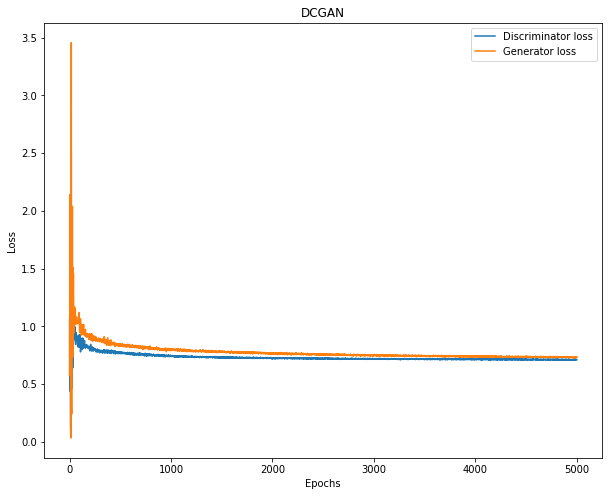

In [0]:
#Latent Dim=100
dcgan = DCGAN()
dcgan.train(epochs=5001,batch_size=5000)

In [0]:
main_run(gen_data_path = "./imgs/DCGAN_1/*.png")

(15000, 784)
(100, 784)
Sigma: 0.1, LL: -232.6507568359375
Sigma: 0.1291549665014884, LL: 90.5695703125
Sigma: 0.16681005372000587, LL: 204.00320129394532
Sigma: 0.21544346900318834, LL: 191.67698776245118
Sigma: 0.2782559402207124, LL: 103.96525527954101
Sigma: 0.35938136638046275, LL: -28.927007255554198
Sigma: 0.46415888336127786, LL: -188.88458114624024
Sigma: 0.5994842503189409, LL: -365.0383538818359
Sigma: 0.774263682681127, LL: -550.8474450683593
Sigma: 1.0, LL: -742.3411627197265
Using Sigma: 0.16681005372000587
Negative Log-Likelihood of Test Set = 208.16402595214845, Std: 2.1448937255688465


In [0]:
# Mehdi
class FMNIST_GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100 #Input Noise Dimension 
        self.losses = {"D_real":[], "D_accuracy":[] ,"G":[]}

        optimizer = Adam(0.0002, 0.5, amsgrad=True)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                    optimizer=optimizer,
                                    metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        #model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=64, sample_interval=200):

        # Load the dataset
        (X_train, _), (_, _) = fashion_mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train -127.5) / 127.5 #- 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        temp=[]
        for epoch in range(epochs+1):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
         
            self.losses["D_real"].append(d_loss[0])
            self.losses["D_accuracy"].append(d_loss[1]) 
            self.losses["G"].append(g_loss)
            #with open('Generic_GAN_mehdi_RMS.pickle', 'wb') as handle:
            #  pickle.dump(self.losses, handle, protocol=pickle.HIGHEST_PROTOCOL)

            # Plot the progress
            
            if epoch%1000==0:
              print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
              self.sample_images(epoch)

            # Checkpointing
            temp.append(100*(1-d_loss[1]))
            if epoch>(epochs-500) and temp[epoch]>temp[epoch-1]:
              self.generator.save("./saved_model/fmnist_generator.h5")

            if epoch == (epochs-1):            
              self.gan_test(model_file="./saved_model/fmnist_generator.h5",path="./imgs/FMNIST/image")
             
        self.plot_loss()

    def gan_test(self, model_file, path,num_examples=15000):
        self.generator = self.build_generator()
        self.generator.load_weights(model_file)
        noise = np.random.normal(0, 1, (num_examples, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        print(gen_imgs.shape)
        
        for i in range(num_examples):
            plt.imsave(path+str(i)+".png", gen_imgs[i, :, :, 0], cmap = "gray")

    def sample_images(self, epoch):
        r, c = 5,5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/fmnist_%d.png" % epoch)
        plt.close()

    def plot_loss(self):
        dis_loss = [v for v in self.losses["D_real"]]
        #dis_accuracy = 100*[v for v in self.losses["D_accuracy"]]
        gen_loss = [v for v in self.losses["G"]]
        #d_acc = [v[1] for v in losses["D"]]
        #g_acc = [v[1] for v in losses["G"]]

        plt.figure(figsize=(10,8))
        plt.plot(dis_loss, label="Discriminator loss")
        #plt.plot(dis_accuracy, label="Discriminator accuracy")
        plt.plot(gen_loss, label="Generator loss")
        #plt.plot(d_acc, label="Discriminator accuracy")
        #plt.plot(g_acc, label="Generator accuracy")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('GAN')
        plt.legend()
        plt.savefig("./FMNIST.png")
        plt.show()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_______________________________________________

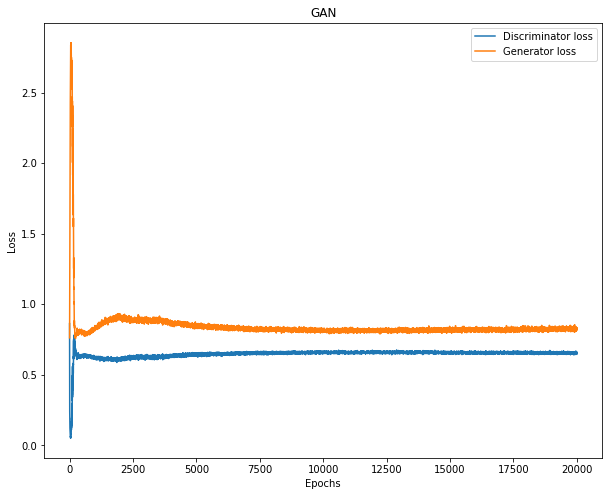

In [26]:
#Latent Dim=100
gan_fmnist = FMNIST_GAN()
gan_fmnist.train(epochs=20001,batch_size=1000)

In [0]:
def log_mean_exp(t):
    # prevent overflow
    # \sum{i=1}^n e^{x_i} = e^\max{x_j} \sum{i=1}^n e^{x_i-\max{x_j}}
    max_ = t.max(1, keepdims=True)
    return np.squeeze(max_) + np.log(np.mean(np.exp(t - max_), 1)) # log-likelihood


def parzen_batch(x, mu, sigma):
    '''
        x: [batch_size, z_dim]
        mu: [n, z_dim]
        sigma: float scalar
    '''

    x = np.expand_dims(x, axis=1)
    mu = np.expand_dims(mu, axis=0)
    t = (((x - mu) / sigma)**2).sum(2)*(-0.5)
    E = log_mean_exp(t)
    Z = mu.shape[2] * np.log(sigma*np.sqrt(2*np.pi))
    return E - Z


def get_lls(x, mu, sigma, batch_size=10):
    lls = np.array([])
    num_samples = x.shape[0]
    num_batches = (num_samples+batch_size-1)//batch_size
    for i in range(num_batches):
        ll = parzen_batch(x[(i*batch_size):min((i+1)*batch_size, num_samples)], mu, sigma)
        lls = np.append(lls, ll)
    return lls


def cross_validate_sigma(x, mu, sigmas, batch_size=10):
    '''
        x: validation data
        mu: generative data
        sigmas: sigma sequence
    '''
    lls = []
    for sigma in sigmas:
        ll = get_lls(x, mu, sigma, batch_size=batch_size)
        lls.append(ll.mean())
        print('Sigma: {}, LL: {}'.format(sigma, ll.mean()))
    return sigmas[np.argmax(lls)]
    


    
def main_run_fmnist(gen_data_path, limit_size = 100, batch_size = 50, cross_val = 10, sigma_start = -1, sigma_end = 0., file = "gan_fmnist.txt"):
#    parser = argparse.ArgumentParser(description = 'Gaussian parzen window, negative log-likelihood estimator.')
#    parser.add_argument('-d', '--data_dir', default='/home/clb/dataset/mnist',  help='Directory to load mnist.')
#    parser.add_argument('-g', '--gen_data_path', default='result/scgan_mnist/scgan_mnist.npy', help='Path to load generative data.')
#    parser.add_argument('-l', '--limit_size', default=1000, type=int, help='The number of samples in validation.')
#    parser.add_argument('-b', '--batch_size', default=100, type=int)
#    parser.add_argument('-c', '--cross_val', default=10, type=int,
#                            help="Number of cross valiation folds")
#    parser.add_argument('--sigma_start', default=-1, type=float)
#    parser.add_argument('--sigma_end', default=0., type=float)
#    parser.add_argument('--file', default='cgan_mnist.txt', help='File to save mean and std of log-likelihood.')
#    args = parser.parse_args()

    # load fmnist
    (trainX, trainY), (testX, testY) = fashion_mnist.load_data()
    trainX = trainX.reshape([-1, 784]).astype(np.float32)/255.
    testX = testX.reshape([-1, 784]).astype(np.float32)/255.

    x = trainX[-limit_size:]
    mu = np.array([cv2.imread(filename, 0) for filename in glob.glob(gen_data_path)]).reshape([-1, 784]).astype(np.float32)/255.
    print(mu.shape)
    print(x.shape)
    #raise Exception("stop")
    #mu = np.load(gen_data_path).astype(np.float32)/255.

    sigmas = np.logspace(sigma_start, sigma_end, cross_val)
    sigma = cross_validate_sigma(x, mu, sigmas, batch_size)
    print('Using Sigma: {}'.format(sigma))
    lls = get_lls(testX, mu, sigma, batch_size)
    print('Negative Log-Likelihood of Test Set = {}, Std: {}'.format(lls.mean(), lls.std()/np.sqrt(testX.shape[0])))
    #with open(file, 'w') as f:
    #    f.write('Negative Log-Likelihood of Test Set = {}, Std: {}\n'.format(lls.mean(), lls.std()/np.sqrt(testX.shape[0]))) 


In [0]:
main_run(gen_data_path = "./imgs/FMNIST/*.png")